In [16]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [17]:
data_path = "sign_data\\train"

Подготовка данных. Фото делятся на пары (true + true, true + false) для последующего сравнения. Все фото приводятся к одному размеру и одинаковому количеству каналов (чёрно-белые изображения). Каждой паре присваивается соответствующая метка (1 если сравниваем оригинал с оригиналом, 0 – оригинал с подделкой). 

In [1]:
import os
import cv2
import numpy as np
from os import listdir

def load_signature_pairs(data_path, height=220, width=155, depth=1):
    dir_names = listdir(data_path)

    images_real = {}
    images_forgery = {}
    labels = set()

    for dir_name in dir_names:
        if dir_name.endswith('_forg'):
            label = dir_name[:-5]  
            is_forgery = True
        else:
            label = dir_name
            is_forgery = False

        labels.add(label)

        if label not in images_real:
            images_real[label] = []

        if label not in images_forgery:
            images_forgery[label] = []

        dir_path = os.path.join(data_path, dir_name)
        image_file_names = listdir(dir_path)

        for image_file_name in image_file_names:
            image_path = os.path.join(dir_path, image_file_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Пропущено изображение: {image_path}")
                continue
            if is_forgery:
                images_forgery[label].append(image)
            else:
                images_real[label].append(image)

    X_base_list = []
    X_comparison_list = []
    y_list = []

    for label in labels:
        real_samples = images_real[label]
        forged_samples = images_forgery[label]

        for i, real_img in enumerate(real_samples):
            real_resized = cv2.resize(real_img, (width, height))

            for j, another_real in enumerate(real_samples):
                another_resized = cv2.resize(another_real, (width, height))
                X_base_list.append(real_resized.reshape((height, width, depth)))
                X_comparison_list.append(another_resized.reshape((height, width, depth)))
                y_list.append(1)

            for another_fake in forged_samples:
                fake_resized = cv2.resize(another_fake, (width, height))
                X_base_list.append(real_resized.reshape((height, width, depth)))
                X_comparison_list.append(fake_resized.reshape((height, width, depth)))
                y_list.append(0)

    X_base = np.array(X_base_list, dtype='uint8')
    X_comparison = np.array(X_comparison_list, dtype='uint8')
    y = np.array(y_list)

    return X_base, X_comparison, y


In [19]:
X_base, X_comparison, y = load_signature_pairs(data_path)

print("X_base shape:", X_base.shape)
print("X_comparison shape:", X_comparison.shape)
print("y shape:", y.shape)
print("Пример меток:", y[:10])
print(f"Labels in y: {np.unique(y)}")


X_base shape: (24093, 220, 155, 1)
X_comparison shape: (24093, 220, 155, 1)
y shape: (24093,)
Пример меток: [1 1 1 1 1 1 1 1 1 1]
Labels in y: [0 1]


In [20]:
indices = np.arange(len(y))
np.random.shuffle(indices)

X_base_shuffled = X_base[indices]
X_comparison_shuffled = X_comparison[indices]
y_shuffled = y[indices]

Просмотр случайной пары

Подготовка наборов для обучения 

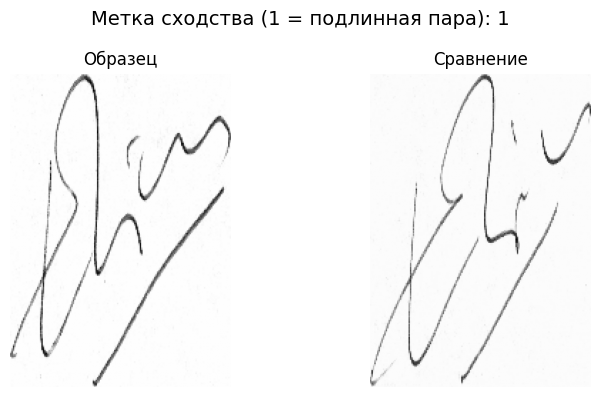

In [6]:
import matplotlib.pyplot as plt
import random

idx = random.randint(0, len(y_shuffled) - 1)
img1 = X_base_shuffled[idx].squeeze()
img2 = X_comparison_shuffled[idx].squeeze()
label = y_shuffled[idx]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(img1, cmap='gray')
axes[0].set_title('Образец')
axes[0].axis('off')

axes[1].imshow(img2, cmap='gray')
axes[1].set_title('Сравнение')
axes[1].axis('off')

plt.suptitle(f'Метка сходства (1 = подлинная пара): {label}', fontsize=14)
plt.tight_layout()
plt.show()

In [21]:
X_base_norm = X_base_shuffled.astype('float32') / 255.
X_comparison_norm = X_comparison_shuffled.astype('float32') / 255.


In [22]:
X_train_base, X_val_base, X_train_comparison, X_val_comparison, y_train, y_val = train_test_split(
    X_base_norm, X_comparison_norm, y_shuffled, test_size=0.2, random_state=42)
print(f"X_train_base shape: {X_train_base.shape}")
print(f"X_val_base shape: {X_val_base.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train_base shape: (19274, 220, 155, 1)
X_val_base shape: (4819, 220, 155, 1)
y_train shape: (19274,)
y_val shape: (4819,)


In [10]:
import joblib
import os

save_dir = 'split_data'
os.makedirs(save_dir, exist_ok=True)

joblib.dump(X_train_base, os.path.join(save_dir, 'X_train_base.pkl'))
joblib.dump(X_val_base, os.path.join(save_dir, 'X_val_base.pkl'))
joblib.dump(X_train_comparison, os.path.join(save_dir, 'X_train_comparison.pkl'))
joblib.dump(X_val_comparison, os.path.join(save_dir, 'X_val_comparison.pkl'))
joblib.dump(y_train, os.path.join(save_dir, 'y_train.pkl'))
joblib.dump(y_val, os.path.join(save_dir, 'y_val.pkl'))


['split_data\\y_val.pkl']

Модель собирается и обучается в другом файле. Далее проверяем модель на тестовом наборе данных

In [23]:
from tensorflow.keras.models import load_model

classifier = load_model('my_model.keras')

In [24]:
data_path_test = "sign_data\\test"

In [25]:
X_base_test, X_comparison_test, y_test = load_signature_pairs(data_path_test)

In [26]:
X_base_test_norm = X_base_test.astype('float32') / 255.
X_comparison_test_norm = X_comparison_test.astype('float32') / 255.

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = classifier.predict([X_base_test_norm, X_comparison_test_norm])

y_pred = (y_pred_probs > 0.5).astype('int').flatten()


188/188 ━━━━━━━━━━━━━━━━━━━━ 68s 351ms/step


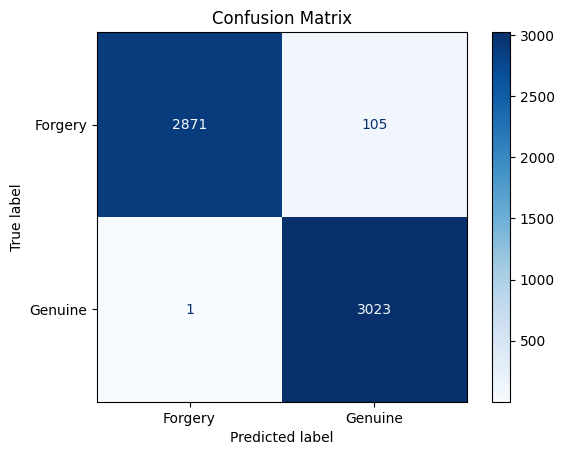

In [28]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Forgery", "Genuine"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Тестирование модели на дополнительных данных собранных не из датасета 

In [29]:
import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


def preprocess_image(path, height=155, width=220):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение: {path}")
    img_resized = cv2.resize(img, (width, height))
    img_disp = img_resized.copy()  
    return img_resized.reshape((1, height, width, 1)).astype('float32') / 255., img_disp


In [30]:
real_dir = "my_sig\\real_new"
test_dir = "my_sig\\test_new"
test_test_dir = "my_sig\\test_test"
real_paths = glob.glob(os.path.join(real_dir, "*.jpg"))
test_paths = glob.glob(os.path.join(test_dir, "*.jpg"))
test_test_paths = glob.glob(os.path.join(test_test_dir, "*.jpg"))


Проверка подписи: test1_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
  Сравнение с test1.jpg → вероятность: 0.0001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
  Сравнение с test10.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
  Сравнение с test2.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
  Сравнение с test3.jpg → вероятность: 0.0001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
  Сравнение с test4.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
  Сравнение с test5.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
  Сравнение с test6.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
  Сравнение с test7.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
  Сравнение с test8.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
  Сравнение с test9.jpg → вероятность: 0.0000


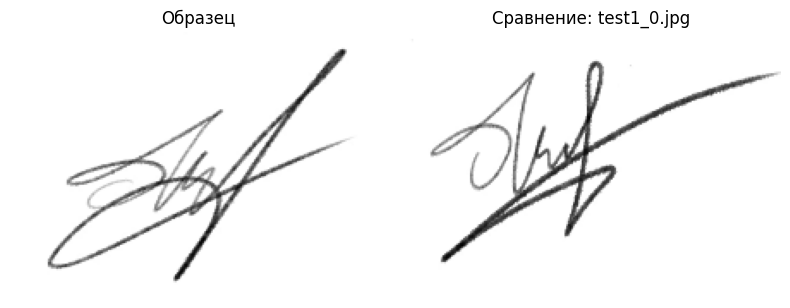

Средняя вероятность подлинности: 0.0000
НЕТ
Проверка подписи: test2_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
  Сравнение с test1.jpg → вероятность: 0.0001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
  Сравнение с test10.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
  Сравнение с test2.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
  Сравнение с test3.jpg → вероятность: 0.0001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
  Сравнение с test4.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
  Сравнение с test5.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
  Сравнение с test6.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
  Сравнение с test7.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
  Сравнение с test8.jpg → вероятность: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
  Сравнение с test9.jpg → вероятность: 0.0000


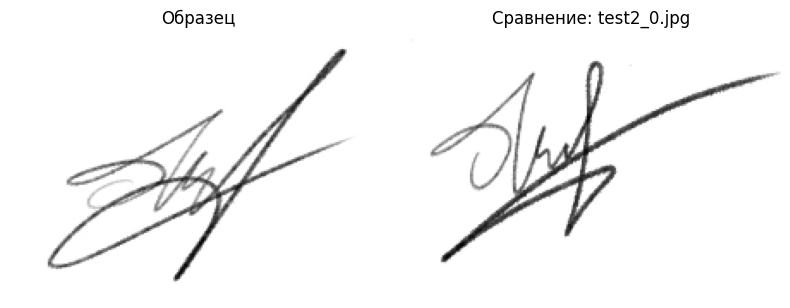

Средняя вероятность подлинности: 0.0000
НЕТ
Проверка подписи: test3_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
  Сравнение с test1.jpg → вероятность: 0.9977
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
  Сравнение с test10.jpg → вероятность: 0.1103
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
  Сравнение с test2.jpg → вероятность: 0.0894
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
  Сравнение с test3.jpg → вероятность: 0.9979
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
  Сравнение с test4.jpg → вероятность: 0.9715
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
  Сравнение с test5.jpg → вероятность: 0.3592
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
  Сравнение с test6.jpg → вероятность: 0.5611
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
  Сравнение с test7.jpg → вероятность: 0.9887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
  Сравнение с test8.jpg → вероятность: 0.9610
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
  Сравнение с test9.jpg → вероятность: 0.3541


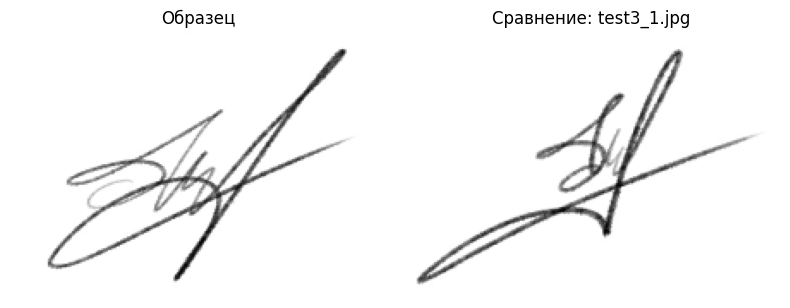

Средняя вероятность подлинности: 0.6391
ДА
Проверка подписи: test4_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
  Сравнение с test1.jpg → вероятность: 0.9998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
  Сравнение с test10.jpg → вероятность: 0.8682
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
  Сравнение с test2.jpg → вероятность: 0.8018
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
  Сравнение с test3.jpg → вероятность: 0.9998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
  Сравнение с test4.jpg → вероятность: 0.9976
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
  Сравнение с test5.jpg → вероятность: 0.9635
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
  Сравнение с test6.jpg → вероятность: 0.9766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
  Сравнение с test7.jpg → вероятность: 0.9990
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
  Сравнение с test8.jpg → вероятность: 0.9966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
  Сравнение с test9.jpg → вероятность: 0.9631


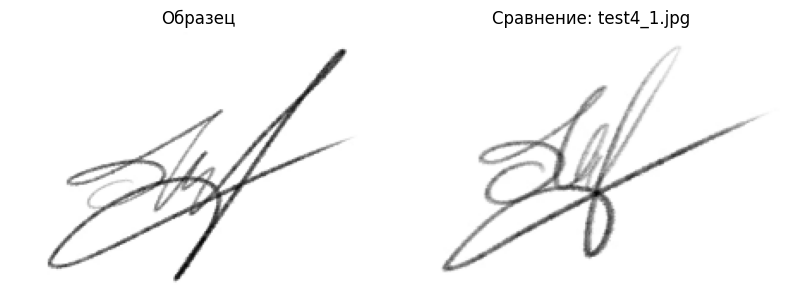

Средняя вероятность подлинности: 0.9566
ДА
Проверка подписи: test5_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
  Сравнение с test1.jpg → вероятность: 0.9991
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
  Сравнение с test10.jpg → вероятность: 0.2863
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
  Сравнение с test2.jpg → вероятность: 0.2089
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
  Сравнение с test3.jpg → вероятность: 0.9992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
  Сравнение с test4.jpg → вероятность: 0.9888
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
  Сравнение с test5.jpg → вероятность: 0.7610
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
  Сравнение с test6.jpg → вероятность: 0.8806
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
  Сравнение с test7.jpg → вероятность: 0.9956
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
  Сравнение с test8.jpg → вероятность: 0.9846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
  Сравнение с test9.jpg → вероятность: 0.7569


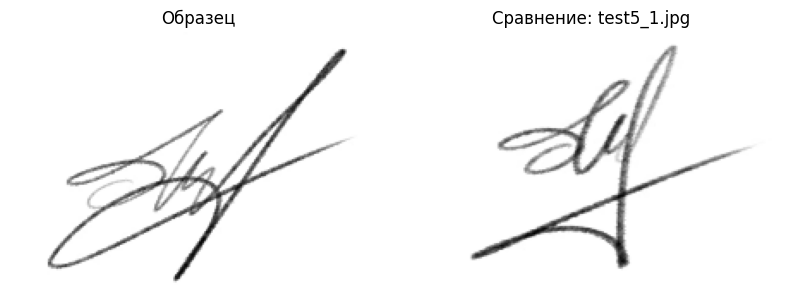

Средняя вероятность подлинности: 0.7861
ДА
Проверка подписи: test6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
  Сравнение с test1.jpg → вероятность: 0.9953
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
  Сравнение с test10.jpg → вероятность: 0.0613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
  Сравнение с test2.jpg → вероятность: 0.0497
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
  Сравнение с test3.jpg → вероятность: 0.9956
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
  Сравнение с test4.jpg → вероятность: 0.9426
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
  Сравнение с test5.jpg → вероятность: 0.1579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
  Сравнение с test6.jpg → вероятность: 0.2573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
  Сравнение с test7.jpg → вероятность: 0.9768
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
  Сравнение с test8.jpg → вероятность: 0.9224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
  Сравнение с test9.jpg → вероятность: 0.1557


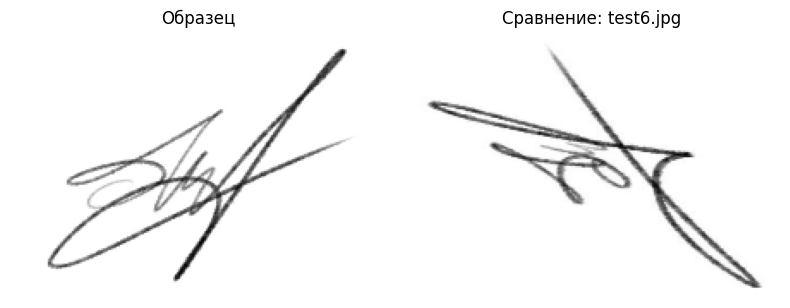

Средняя вероятность подлинности: 0.5515
ДА
Проверка подписи: test7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
  Сравнение с test1.jpg → вероятность: 0.9969
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
  Сравнение с test10.jpg → вероятность: 0.0850
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
  Сравнение с test2.jpg → вероятность: 0.0691
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
  Сравнение с test3.jpg → вероятность: 0.9971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
  Сравнение с test4.jpg → вероятность: 0.9613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
  Сравнение с test5.jpg → вероятность: 0.2437
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
  Сравнение с test6.jpg → вероятность: 0.4173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
  Сравнение с test7.jpg → вероятность: 0.9845
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
  Сравнение с test8.jpg → вероятность: 0.9473
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
  Сравнение с test9.jpg → вероятность: 0.2396


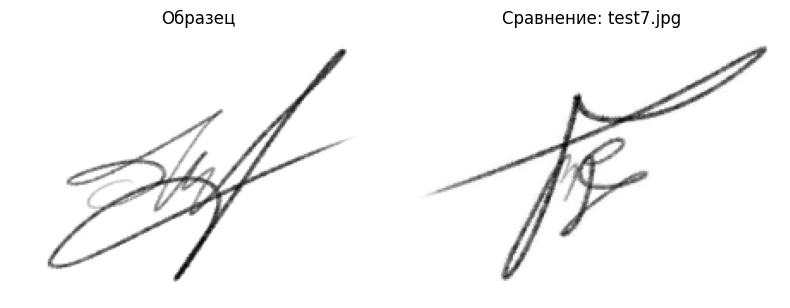

Средняя вероятность подлинности: 0.5942
ДА
Проверка подписи: test8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
  Сравнение с test1.jpg → вероятность: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
  Сравнение с test10.jpg → вероятность: 0.9974
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
  Сравнение с test2.jpg → вероятность: 0.9966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
  Сравнение с test3.jpg → вероятность: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
  Сравнение с test4.jpg → вероятность: 0.9999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
  Сравнение с test5.jpg → вероятность: 0.9992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
  Сравнение с test6.jpg → вероятность: 0.9995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
  Сравнение с test7.jpg → вероятность: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
  Сравнение с test8.jpg → вероятность: 0.9999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
  Сравнение с test9.jpg → вероятность: 0.9992


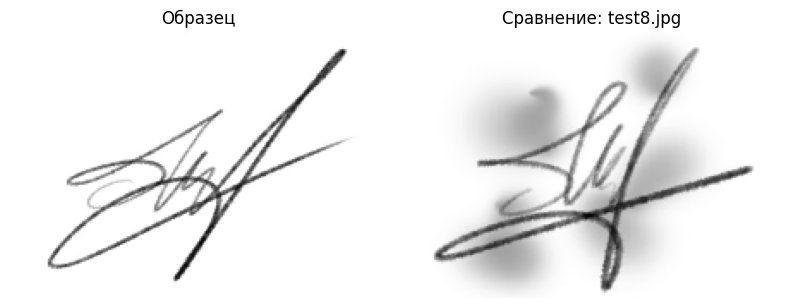

Средняя вероятность подлинности: 0.9992
ДА
Проверка подписи: test9.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
  Сравнение с test1.jpg → вероятность: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
  Сравнение с test10.jpg → вероятность: 0.9711
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
  Сравнение с test2.jpg → вероятность: 0.9626
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
  Сравнение с test3.jpg → вероятность: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
  Сравнение с test4.jpg → вероятность: 0.9994
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
  Сравнение с test5.jpg → вероятность: 0.9906
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
  Сравнение с test6.jpg → вероятность: 0.9940
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
  Сравнение с test7.jpg → вероятность: 0.9998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
  Сравнение с test8.jpg → вероятность: 0.9992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
  Сравнение с test9.jpg → вероятность: 0.9904


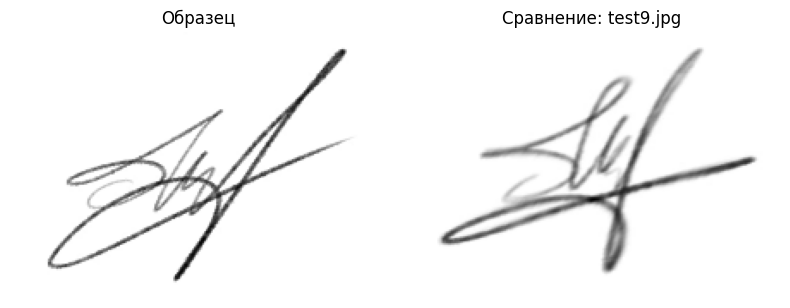

Средняя вероятность подлинности: 0.9907
ДА


In [34]:
for test_path in test_test_paths:
    print(f"Проверка подписи: {os.path.basename(test_path)}")

    test_img, test_img_disp = preprocess_image(test_path)
    results = []

    for real_path in real_paths:
        real_img, real_img_disp = preprocess_image(real_path)
        prob = classifier.predict([real_img, test_img])[0][0]
        results.append((prob, real_img_disp))
        print(f"  Сравнение с {os.path.basename(real_path)} → вероятность: {prob:.4f}")

    best_match_idx = np.argmax([r[0] for r in results])
    best_match_img = results[best_match_idx][1]
    best_prob = results[best_match_idx][0]

     
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(best_match_img, cmap='gray')
    axes[0].set_title('Образец')
    axes[0].axis('off')

    axes[1].imshow(test_img_disp, cmap='gray')
    axes[1].set_title(f'Сравнение: {os.path.basename(test_path)}')
    axes[1].axis('off')


    plt.tight_layout()
    plt.show()

    avg_score = np.mean([r[0] for r in results])
    print(f"Средняя вероятность подлинности: {avg_score:.4f}")
    if avg_score > 0.5:
        print("ДА")
    else:
        print("НЕТ")